In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import pytorch_lightning as pl
import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from pytorch_lightning import loggers as pl_loggers

from sklearn import decomposition
import scipy
from scipy.integrate import solve_ivp

from sklearn.feature_extraction import image

from utils import *

# L63 Data simulation

In [4]:
Training_dataset,Val_dataset,Test_dataset = L63PatchDataExtraction(sparsity=0.5,sigma_noise=np.sqrt(2),num_variables=3)


meanTr          = np.mean(Training_dataset['Missing']) / np.mean(Training_dataset['Mask']) 
stdTr           = np.sqrt( np.mean( Training_dataset['Missing']**2 ) / np.mean(Training_dataset['Mask']) )


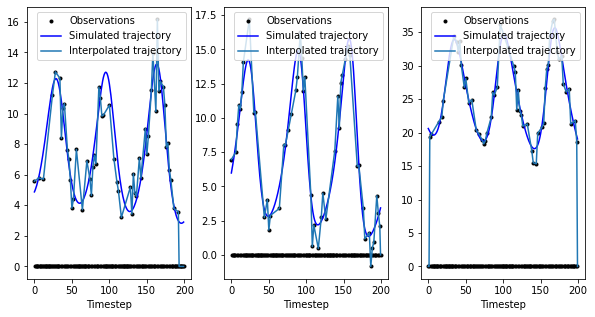

In [5]:
visualisation_data(Training_dataset['Truth'],Training_dataset['Obs'],Training_dataset['Init'],125)

# Baseline 1 - 4D Var


In [6]:


class Int(torch.nn.Module):
    def __init__(self):
        super(Int, self).__init__()

        self.sigma  = torch.nn.Parameter(torch.Tensor([10.]))
        self.rho    = torch.nn.Parameter(torch.Tensor([28.]))
        self.beta   = torch.nn.Parameter(torch.Tensor([8./3.]))

        self.dt        = 0.01
        self.IntScheme = 0
        self.stdTr     = stdTr
        self.meanTr    = meanTr                      
    def _odeL63(self, xin):
        x1  = xin[:,:,0]
        x2  = xin[:,:,1]
        x3  = xin[:,:,2]
            
        dx_1 = (self.sigma*(x2-x1)).view(-1,xin.size(1),1)
        dx_2 = (x1*(self.rho-x3)-x2).view(-1,xin.size(1),1)
        dx_3 = (x1*x2 - self.beta*x3).view(-1,xin.size(1),1)
         
        dpred = torch.cat((dx_1,dx_2,dx_3),dim=2)
        
        return dpred

    def _EulerSolver(self, x):
        return x + self.dt * self._odeL63(x)
      
    def forward(self, x):
            
            xpred = self._EulerSolver( x[:,0:x.size(1)-1,:])
            
            
            xnew  = torch.cat((x[:,0,:].view(-1,1,3),xpred),dim=1)
            return xnew
    
modelInt      = Int()
    



In [7]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelInt          = modelInt.to(device)
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(Test_dataset['Init']),torch.Tensor(Test_dataset['Obs']),torch.Tensor(Test_dataset['Mask']),torch.Tensor(Test_dataset['Truth'])) # create your datset
batch_size = 128
dataloaders = {
    'dataset': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
}            
dataset_sizes = {'dataset': len(test_dataset)}

comptUpdate = 1
iterInit    = 0
iterStateUpdate = 250 
NIterGrad       = 5000
modIter         = 100
delta           = 1e4 
alpha           = 1e0* np.array([.01,0.99])

xhat_tot = []
numData  = 0
compt    = 0
for x_init,x_obs,masks,x_GT in dataloaders['dataset']:
    x_init    = x_init.to(device)
    x_obs     = x_obs.to(device)
    masks     = masks.to(device)
    x_GT      = x_GT.to(device)

    numData +=  x_GT.size(0)

    # initialisation
    xhat = x_init 
    xhat = torch.autograd.Variable(xhat, requires_grad=True)

    # 4DVar assimilation using trained gradient descent
    losses_test = []
    compt_kk = 0
    for kk in range(0,NIterGrad):     
        # AE projection
        x_pred = modelInt( xhat )
        
        # dynamical loss
        loss_dyn = torch.mean((xhat - x_pred)**2 )
    
        # observation loss
        loss_obs = torch.sum((xhat - x_obs)**2 * masks) / torch.sum( masks)
    
        ## loss wrt groudn-truth
        loss_GT  = torch.mean((xhat - x_GT)**2)

        # overall loss
        loss = alpha[0] * loss_obs + alpha[1] * loss_dyn 
    
        # compute gradient w.r.t. X and update X
        loss.backward()
        
        #grad_X  = torch.autograd.grad(loss,X_torch,create_graph=True)
        xhat = xhat - delta * xhat.grad.data
        xhat = torch.autograd.Variable(xhat, requires_grad=True)                                           
        # other loss types
        dB          = 0
        dT          = xhat.size(2)
        loss_R      = torch.sum( (xhat[:,dB:dT-dB] - x_GT[:,dB:dT-dB])**2 * masks[:,dB:dT-dB] )
        loss_R      = loss_R / torch.sum( masks[:,dB:dT-dB] )
        loss_AE_GT  = torch.mean( (modelInt(x_GT)[:,dB:dT-dB] - x_GT[:,dB:dT-dB])**2 )        
        loss_I      = torch.sum( (xhat[:,dB:dT-dB] - x_GT[:,dB:dT-dB])**2 * (1. - masks[:,dB:dT-dB]) )
        loss_I      = loss_I / torch.sum( (1. - masks[:,dB:dT-dB]) )

        # evaluate and store losses
        if( np.mod(kk,modIter) == 0 ):  
            # store as np
            if( compt_kk == 0 ):
                losses_test = torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()                                
            else:
                losses_test = np.concatenate( (losses_test,torch.cat( (loss_GT.view(1,1),loss_dyn.view(1,1),loss_obs.view(1,1),loss_R.view(1,1),loss_I.view(1,1)), dim = 1 ).cpu().detach().numpy()) , axis = 0)
            compt_kk += 1
    xhat_tot.append(xhat)
    if compt == 0 :
        loss4DVar = x_GT.size(0) * losses_test
    else :
        loss4DVar = loss4DVar + x_GT.size(0) * losses_test
    compt += 1
    

loss4DVar = stdTr**2 * loss4DVar / numData
                            


0.38786966


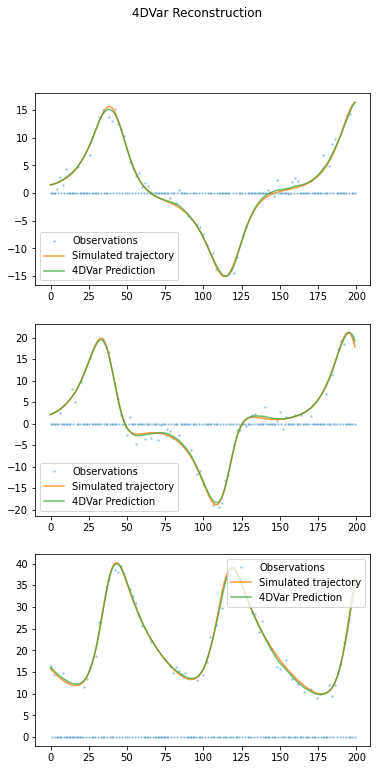

In [8]:
visualisation4DVar(3,x_obs,x_GT,xhat)
R_score = reconstruction_error_4DVar(x_GT,xhat)
print(R_score)

# Baseline 2 : Model CNN



In [16]:
shapeData  = Training_dataset['Truth'].shape[1:]
dW =1
dimCNN = 10
class CNN(pl.LightningModule):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1  = torch.nn.Conv1d(shapeData[1],shapeData[1]*dimCNN,2*dW+1,padding=dW,bias=False)
        self.conv2  = torch.nn.Conv1d(shapeData[1]*dimCNN,shapeData[1]*dimCNN,2*dW+1,padding=dW,bias=False)
        self.conv3  = torch.nn.Conv1d(shapeData[1]*dimCNN,shapeData[1]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv4  = torch.nn.Conv1d(shapeData[1]*dimCNN,shapeData[1]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv5  = torch.nn.Conv1d(shapeData[1]*dimCNN,shapeData[1]*dimCNN,2*dW+1,padding=dW,bias=False)
        #self.conv6  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,1,padding=0,bias=False)
        self.conv7  = torch.nn.Conv1d(shapeData[1]*dimCNN,shapeData[1],1,padding=0,bias=False)

        self.tot_loss=[]
        self.tot_val_loss=[]
        self.batch_size=128
        self.best_loss=1e10
        
    def forward(self,xinp):
        xinp = xinp.view(-1,shapeData[1],shapeData[0])
        x = self.conv1( xinp )
        x = self.conv2( F.relu(x) )
        x = self.conv3( F.relu(x) )
        #x = self.conv4( F.relu(x) )
        #x = self.conv5( F.relu(x) )
        #x = self.conv6( F.relu(x) )
        x = self.conv7( F.relu(x) )
        x = x.view(-1,shapeData[0],shapeData[1])

        return x
    def setup(self,stage='None'):
        batch_size=128
        training_dataset   = torch.utils.data.TensorDataset(torch.Tensor(Training_dataset['Init']),torch.Tensor(Training_dataset['Obs']),torch.Tensor(Training_dataset['Mask']),torch.Tensor(Training_dataset['Truth'])) 
        val_dataset        = torch.utils.data.TensorDataset(torch.Tensor(Val_dataset['Init']),torch.Tensor(Val_dataset['Obs']),torch.Tensor(Val_dataset['Mask']),torch.Tensor(Val_dataset['Truth']))
        test_dataset       = torch.utils.data.TensorDataset(torch.Tensor(Test_dataset['Init']),torch.Tensor(Test_dataset['Obs']),torch.Tensor(Test_dataset['Mask']),torch.Tensor(Test_dataset['Truth'])) 
        self.dataloaders = {
            'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
            'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0),
            'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)}

        
    def loss(self, x, y):
         return torch.mean((x - y)**2 )
    
    def training_step(self, train_batch, batch_idx):
        running_loss = 0.0
        num_loss     = 0
        
        inputs_init,inputs_missing,masks,targets_GT  = train_batch
        inputs_init    = torch.autograd.Variable(inputs_init, requires_grad=True)
        outputs     = self(inputs_init)
        loss      = torch.mean((outputs - targets_GT)**2 )
        
        running_loss             += loss.item() * inputs_missing.size(0)
        num_loss                 += inputs_missing.size(0)
        epoch_loss       = running_loss / num_loss
        self.tot_loss.append(epoch_loss)
        
        
        
        self.log('train_loss', epoch_loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        inputs_init,inputs_missing,masks,targets_GT  = val_batch
        running_val_loss = 0.0
        num_val_loss     = 0

        outputs     = self(inputs_init)
        loss      = torch.mean((outputs - targets_GT)**2 )
           
        running_val_loss             += loss.item() * inputs_missing.size(0)
        num_val_loss                 += inputs_missing.size(0)
        epoch_val_loss       = running_val_loss / num_val_loss
        self.tot_val_loss.append(epoch_val_loss)
        

        
        self.log('val_loss', loss ,prog_bar=False,logger=False)
        if  epoch_val_loss < self.best_loss:
            self.best_loss = epoch_val_loss
            self.best_model_wts = copy.deepcopy(self.state_dict())

        return epoch_val_loss

    def configure_optimizers(self):
        self.optimizer      = optim.Adam(self.parameters(), lr=5e-3)
        
        return self.optimizer
    
    def train_dataloader(self):
        return self.dataloaders['train']
    
    def val_dataloader(self):
        return self.dataloaders['val']
    
    def test_dataloader(self):
        return self.dataloaders['test']

In [17]:
model_CNN = CNN()

print(model_CNN)
print('CNN : Number of trainable parameters = %d'%(sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)))

tb_logger = pl_loggers.TensorBoardLogger("logs/")
#Train the model
trainer = pl.Trainer(logger=tb_logger,max_epochs=20,enable_progress_bar=True,limit_train_batches=1.0)
trainer.fit(model_CNN)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


CNN(
  (conv1): Conv1d(3, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv2): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv3): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv7): Conv1d(30, 3, kernel_size=(1,), stride=(1,), bias=False)
)
CNN : Number of trainable parameters = 5760



  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv1d | 270   
1 | conv2 | Conv1d | 2.7 K 
2 | conv3 | Conv1d | 2.7 K 
3 | conv7 | Conv1d | 90    
---------------------------------
5.8 K     Trainable params
0         Non-trainable params
5.8 K     Total params
0.023     Total estimated model params size (MB)


/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 0:  83%|██████████  | 100/120 [00:04<00:00, 21.69it/s, loss=6.17, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|██████████  | 100/120 [00:04<00:00, 21.81it/s, loss=4.97, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|██████████▊  | 100/120 [00:04<00:00, 21.02it/s, loss=4.5, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 3:  83%|██████████▊  | 100/120 [00:04<00:00, 21.70it/s, loss=3.9, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|██████████  | 100/120 [00:04<00:00, 22.02it/s, loss=3.49, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 5:  83%|██████████  | 100/120 [00:04<00:00, 21.75it/s, loss=3.17, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 6:  83%|██████████  | 100/120 [00:04<00:00, 21.74it/s, loss=2.81, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 7:  83%|██████████  | 100/120 [00:04<00:00, 21.62it/s, loss=2.76, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 8:  83%|██████████  | 100/120 [00:04<00:00, 21.77it/s, loss=2.72, v_num=1]
Validating: 0it [00:00,

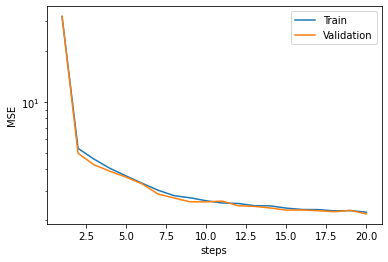

In [18]:
plot_loss(model_CNN,max_epoch=20)

In [13]:
from importlib import reload
import utils
reload(utils) 
from utils import *

Variables reconstruction score : [ 7.33044971  7.85290159 16.54725399]
Global reconstruction score : 10.576868429396848


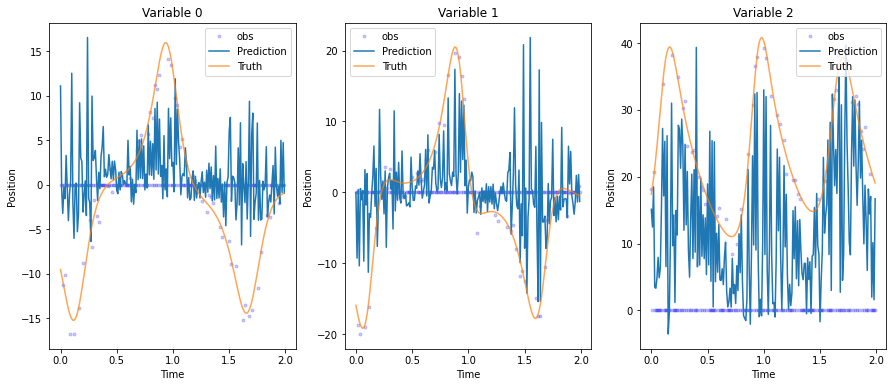

In [19]:
plot_prediction(model_CNN,idx=25,dataset = Test_dataset)

r_score = R_score(model_CNN,dataset = Test_dataset)


## Two variables observations

In [99]:
Training_dataset,Val_dataset,Test_dataset = L63PatchDataExtraction(sparsity=0.5,sigma_noise=np.sqrt(2),num_variables=2)


meanTr          = np.mean(Training_dataset['Missing']) / np.mean(Training_dataset['Mask']) 
stdTr           = np.sqrt( np.mean( Training_dataset['Missing']**2 ) / np.mean(Training_dataset['Mask']) )


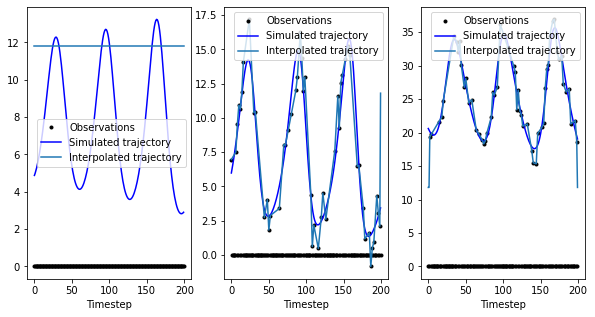

In [76]:
visualisation_data(Training_dataset['Truth'],Training_dataset['Obs'],Training_dataset['Init'],125)

In [100]:
model_CNN = CNN()

print(model_CNN)
print('CNN : Number of trainable parameters = %d'%(sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)))

tb_logger = pl_loggers.TensorBoardLogger("logs/")
#Train the model
trainer = pl.Trainer(logger=tb_logger,max_epochs=25,enable_progress_bar=True,limit_train_batches=1.0)
trainer.fit(model_CNN)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv1d | 1.5 K 
1 | conv2 | Conv1d | 15.3 K
2 | conv3 | Conv1d | 15.3 K
3 | conv4 | Conv1d | 15.3 K
4 | conv5 | Conv1d | 15.3 K
5 | conv7 | Conv1d | 90    
---------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)


CNN(
  (conv1): Conv1d(3, 30, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (conv2): Conv1d(30, 30, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (conv3): Conv1d(30, 30, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (conv4): Conv1d(30, 30, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (conv5): Conv1d(30, 30, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (conv7): Conv1d(30, 3, kernel_size=(1,), stride=(1,), bias=False)
)
CNN : Number of trainable parameters = 62820
Validation sanity check:   0%|                            | 0/2 [00:00<?, ?it/s]

/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 0:  83%|█████████▏ | 100/120 [00:40<00:08,  2.49it/s, loss=12.2, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|█████████▏ | 100/120 [00:40<00:08,  2.50it/s, loss=5.36, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|█████████▏ | 100/120 [00:39<00:07,  2.51it/s, loss=4.21, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 3:  83%|█████████▏ | 100/120 [00:39<00:07,  2.53it/s, loss=3.61, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|█████████▏ | 100/120 [00:39<00:07,  2.53it/s, loss=3.34, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 5:  83%|█████████▏ | 100/120 [00:39<00:07,  2.54it/s, loss=3.17, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 6:  83%|█████████▏ | 100/120 [00:39<00:07,  2.53it/s, loss=2.72, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 7:  83%|█████████▏ | 100/120 [00:40<00:08,  2.49it/s, loss=2.68, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 8:  83%|█████████▏ | 100/120 [00:40<00:08,  2.46it/s, loss=2.39, v_num=20]
Validating: 0it [00:00,

Epoch 9:  83%|█████████▏ | 100/120 [00:39<00:07,  2.51it/s, loss=2.51, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 10:  83%|████████▎ | 100/120 [00:40<00:08,  2.50it/s, loss=2.26, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 11:  83%|████████▎ | 100/120 [00:40<00:08,  2.50it/s, loss=2.12, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 12:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=2.11, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 13:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=2.17, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 14:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=1.91, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 15:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=2.02, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 16:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=1.92, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 17:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=1.87, v_num=20]
Validating: 0it [00:00,

Epoch 18:  83%|████████▎ | 100/120 [00:39<00:07,  2.52it/s, loss=1.77, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 19:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=1.66, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 20:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=1.71, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 21:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=1.53, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 22:  83%|████████▎ | 100/120 [00:39<00:07,  2.52it/s, loss=1.62, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 23:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=1.61, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 24:  83%|████████▎ | 100/120 [00:39<00:07,  2.52it/s, loss=1.71, v_num=20]
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|██████████| 120/120 [00:42<00:00,  2.84it/s, loss=1.71, v_num=20]


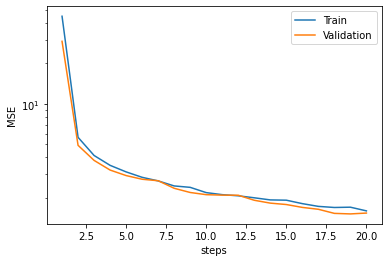

In [101]:
plot_loss(model_CNN,max_epoch=20)

Variables reconstruction score : [1.3288454 1.1927805 1.2180362]
Global reconstruction score : 1.2465540170669556


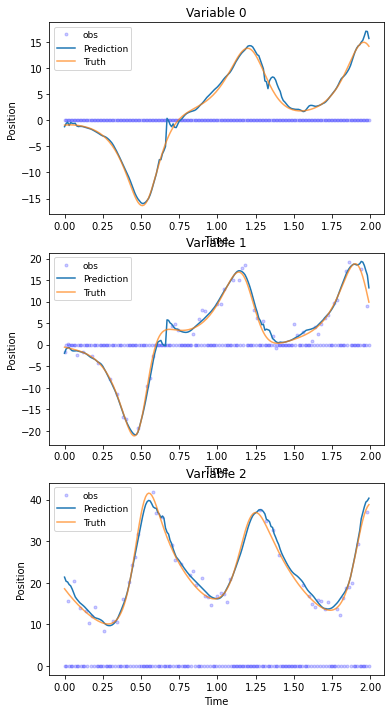

In [102]:
plot_prediction(model_CNN,idx=26,dataset = Test_dataset)

r_score = R_score(model_CNN,dataset = Test_dataset)


## One variable observations

In [103]:
Training_dataset,Val_dataset,Test_dataset = L63PatchDataExtraction(sparsity=0.5,sigma_noise=np.sqrt(2),num_variables=1)


meanTr          = np.mean(Training_dataset['Missing']) / np.mean(Training_dataset['Mask']) 
stdTr           = np.sqrt( np.mean( Training_dataset['Missing']**2 ) / np.mean(Training_dataset['Mask']) )


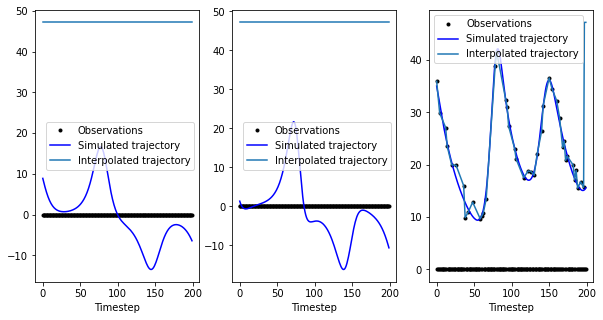

In [104]:
visualisation_data(Training_dataset['Truth'],Training_dataset['Obs'],Training_dataset['Init'],115)

In [105]:
model_CNN = CNN()

print(model_CNN)
print('CNN : Number of trainable parameters = %d'%(sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)))

tb_logger = pl_loggers.TensorBoardLogger("logs/")
#Train the model
trainer = pl.Trainer(logger=tb_logger,max_epochs=30,enable_progress_bar=True,limit_train_batches=1.0)
trainer.fit(model_CNN)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv1d | 1.5 K 
1 | conv2 | Conv1d | 15.3 K
2 | conv3 | Conv1d | 15.3 K
3 | conv4 | Conv1d | 15.3 K
4 | conv5 | Conv1d | 15.3 K
5 | conv7 | Conv1d | 90    
---------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)


CNN(
  (conv1): Conv1d(3, 30, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (conv2): Conv1d(30, 30, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (conv3): Conv1d(30, 30, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (conv4): Conv1d(30, 30, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (conv5): Conv1d(30, 30, kernel_size=(17,), stride=(1,), padding=(8,), bias=False)
  (conv7): Conv1d(30, 3, kernel_size=(1,), stride=(1,), bias=False)
)
CNN : Number of trainable parameters = 62820
Validation sanity check:   0%|                            | 0/2 [00:00<?, ?it/s]

/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


/Users/charlottedurand/opt/anaconda3/envs/tf_2/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 0:  83%|█████████▏ | 100/120 [00:39<00:07,  2.52it/s, loss=55.2, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|█████████▏ | 100/120 [00:39<00:07,  2.55it/s, loss=50.7, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|█████████▏ | 100/120 [00:39<00:07,  2.53it/s, loss=49.8, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 3:  83%|█████████▏ | 100/120 [00:39<00:07,  2.55it/s, loss=49.6, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|█████████▏ | 100/120 [00:39<00:07,  2.54it/s, loss=49.6, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 5:  83%|█████████▏ | 100/120 [00:39<00:07,  2.54it/s, loss=49.4, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 6:  83%|█████████▏ | 100/120 [00:39<00:07,  2.54it/s, loss=49.3, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 7:  83%|█████████▏ | 100/120 [00:39<00:07,  2.54it/s, loss=49.3, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 8:  83%|██████████▊  | 100/120 [00:39<00:07,  2.54it/s, loss=49, v_num=21]
Validating: 0it [00:00,

Epoch 9:  83%|█████████▏ | 100/120 [00:39<00:07,  2.54it/s, loss=49.1, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 10:  83%|████████▎ | 100/120 [00:39<00:07,  2.54it/s, loss=49.1, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 11:  83%|████████▎ | 100/120 [00:39<00:07,  2.54it/s, loss=48.9, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 12:  83%|██████████  | 100/120 [00:40<00:08,  2.50it/s, loss=49, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 13:  83%|████████▎ | 100/120 [00:40<00:08,  2.44it/s, loss=48.8, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 14:  83%|████████▎ | 100/120 [00:39<00:07,  2.52it/s, loss=48.7, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 15:  83%|████████▎ | 100/120 [00:39<00:07,  2.52it/s, loss=48.7, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 16:  83%|████████▎ | 100/120 [00:39<00:07,  2.53it/s, loss=48.7, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 17:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=48.7, v_num=21]
Validating: 0it [00:00,

Epoch 18:  83%|████████▎ | 100/120 [00:39<00:07,  2.52it/s, loss=48.8, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 19:  83%|████████▎ | 100/120 [00:39<00:07,  2.54it/s, loss=48.8, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 20:  83%|████████▎ | 100/120 [00:39<00:07,  2.54it/s, loss=48.8, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 21:  83%|████████▎ | 100/120 [00:39<00:07,  2.54it/s, loss=48.6, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 22:  83%|████████▎ | 100/120 [00:39<00:07,  2.53it/s, loss=48.7, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 23:  83%|████████▎ | 100/120 [00:39<00:07,  2.53it/s, loss=48.8, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 24:  83%|████████▎ | 100/120 [00:39<00:07,  2.52it/s, loss=48.8, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 25:  83%|████████▎ | 100/120 [00:39<00:07,  2.51it/s, loss=48.7, v_num=21]
Validating: 0it [00:00, ?it/s]
Validating:  90%|███████████████████████████▉   | 18/20 [00:02<00:00,  7.58it/s]


Epoch 26:  83%|████████▎ | 100/120 [00:40<00:08,  2.49it/s, loss=48.6, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 27:  83%|████████▎ | 100/120 [00:39<00:07,  2.53it/s, loss=48.7, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 28:  83%|████████▎ | 100/120 [00:39<00:07,  2.54it/s, loss=48.8, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 29:  83%|████████▎ | 100/120 [00:39<00:07,  2.54it/s, loss=48.6, v_num=21]
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████| 120/120 [00:42<00:00,  2.85it/s, loss=48.6, v_num=21]


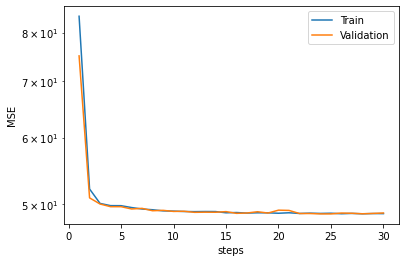

In [106]:
plot_loss(model_CNN,max_epoch=30)

Variables reconstruction score : [7.9279046 9.020522  1.3525057]
Global reconstruction score : 6.100311279296875


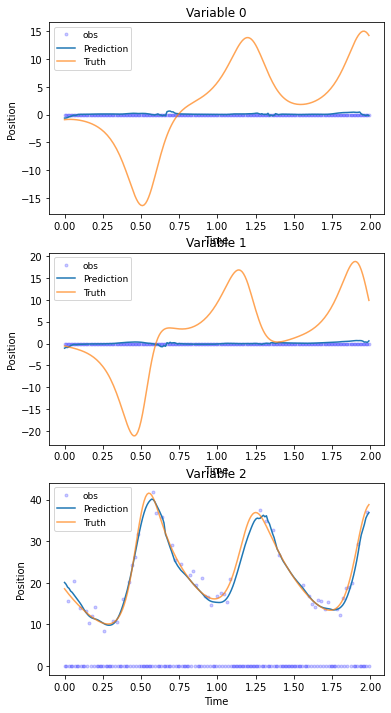

In [108]:
plot_prediction(model_CNN,idx=26,dataset = Test_dataset)

r_score = R_score(model_CNN,dataset = Test_dataset)
